In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#necessary imports
import sys
import math
import scipy
import random
import logging
import warnings
import operator
import copy as cp
import numpy as np
from numpy import *
import pandas as pd
import array as arr
from copy import copy
from time import time
import seaborn as sns
from sklearn import svm
from scipy import sparse
from scipy import optimize
from qns3vm import QN_S3VM
from sklearn import metrics
from sklearn.svm import SVC 
from numpy import concatenate
import scipy.sparse.csc as csc
warnings.simplefilter('error')
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading 
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import SelfTrainingClassifier
from scipy.spatial.distance import cdist, pdist, squareform

In [3]:
#loading datasets 
train_unlab = pd.read_csv("/content/drive/MyDrive/tra.csv")
train_lab = pd.read_csv("/content/drive/MyDrive/trs.csv")
test_lab = pd.read_csv("/content/drive/MyDrive/tst.csv")

In [4]:
print(train_unlab.shape, train_lab.shape, test_lab.shape)

(959, 12) (959, 12) (107, 12)


In [5]:
#concatenating both the train datasets since the unlabeled dataset has labeled values 
train = pd.concat([train_lab, train_unlab], axis=0)
train[' Class'].value_counts()

 unlabeled    576
 H            423
 D            296
 C            264
 B            183
 E            123
 F             53
Name:  Class, dtype: int64

In [6]:
#splitting labeled and unlabeled data from the concatenated dataframe 
df_lab = train.iloc[:1341,:]
df_unlab = train.iloc[1342:,:]

print(df_lab.shape, df_unlab.shape)

(1341, 12) (576, 12)


In [7]:
df_lab= df_lab.loc[~df_lab.index.duplicated(), :]
df_lab[df_lab.index.duplicated()]

,LargestSpotSize,SpotDistribution,Activity,Evolution,Prev24Hour,HistComplex,BecomeHist,Area,C-class,M-class,X-class,Class


In [8]:
print(df_lab.shape, df_unlab.shape)

(959, 12) (576, 12)


In [9]:
#converting numerical columns with 2 types to binary values 
df_lab[' Activity'] = df_lab[' Activity'].replace([1, 2], [0, 1])
df_unlab[' Activity'] = df_unlab[' Activity'].replace([1, 2], [0, 1])
test_lab[' Activity'] = test_lab[' Activity'].replace([1, 2], [0, 1])

df_lab[' HistComplex'] = df_lab[' HistComplex'].replace([1, 2], [0, 1])
df_unlab[' HistComplex'] = df_unlab[' HistComplex'].replace([1, 2], [0, 1])
test_lab[' HistComplex'] = test_lab[' HistComplex'].replace([1, 2], [0, 1])

df_lab[' BecomeHist'] = df_lab[' BecomeHist'].replace([1, 2], [0, 1])
df_unlab[' BecomeHist'] = df_unlab[' BecomeHist'].replace([1, 2], [0, 1])
test_lab[' BecomeHist'] = test_lab[' BecomeHist'].replace([1, 2], [0, 1])

df_lab[' Area'] = df_lab[' Area'].replace([1, 2], [0, 1])
df_unlab[' Area'] = df_unlab[' Area'].replace([1, 2], [0, 1])
test_lab[' Area'] = test_lab[' Area'].replace([1, 2], [0, 1])

In [10]:
#scaling the numerical columns  
mms = MinMaxScaler()
df_lab[[' C-class', ' M-class', ' X-Class']] = mms.fit_transform(df_lab[[' C-class', ' M-class', ' X-class']])
df_unlab[[' C-class', ' M-class', ' X-Class']] = mms.fit_transform(df_unlab[[' C-class', ' M-class', ' X-class']])
test_lab[[' C-class', ' M-class', ' X-Class']] = mms.fit_transform(test_lab[[' C-class', ' M-class', ' X-class']])

In [11]:
#get dummies for categorical columns 
df_lab = pd.get_dummies(data = df_lab, columns = ['LargestSpotSize', ' SpotDistribution', ' Evolution', 'Prev24Hour'])
df_unlab = pd.get_dummies(df_unlab, columns = ['LargestSpotSize', ' SpotDistribution', ' Evolution', 'Prev24Hour'])
test_lab = pd.get_dummies(test_lab, columns = ['LargestSpotSize', ' SpotDistribution', ' Evolution', 'Prev24Hour'])

le = LabelEncoder()

In [12]:
#X and y split
X_train_unlab = df_unlab.drop([' Class'], axis=1)
y_train_unlab = np.array([-1] * len(X_train_unlab))

X_train_lab = df_lab.drop([' Class'], axis=1)
y_train_lab = df_lab[' Class']
y_train_lab = le.fit_transform(y_train_lab)

X_test = test_lab.drop([' Class'], axis=1)
X_test['Prev24Hour_2'] = np.array([0]* len(X_test))
y_test = test_lab[' Class']
y_test = le.fit_transform(y_test)

In [13]:
np.unique(y_train_lab, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([133, 189, 216,  85,  39, 297]))

In [14]:
#balancing the classes
sm = SMOTE(random_state=42)
X_train_lab, y_train_lab = sm.fit_resample(X_train_lab, y_train_lab)

In [15]:
#summarize train set size
print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
print('Unlabeled Train Set:', X_train_unlab.shape, y_train_unlab.shape)

#summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1782, 24) (1782,)
Unlabeled Train Set: (576, 24) (576,)
Test Set: (107, 24) (107,)


#**Baseline Models**

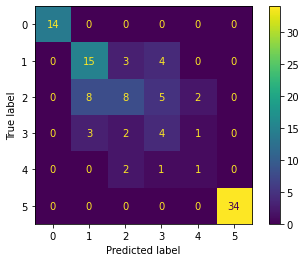

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.58      0.68      0.62        22
           2       0.53      0.35      0.42        23
           3       0.29      0.40      0.33        10
           4       0.25      0.25      0.25         4
           5       1.00      1.00      1.00        34

    accuracy                           0.71       107
   macro avg       0.61      0.61      0.60       107
weighted avg       0.72      0.71      0.71       107

Train accuracy Score: 0.7530864197530864
Test accuracy Score: 0.7102803738317757


In [16]:
#baseline SVM for labeled data 
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train_lab, y_train_lab)
y_pred_test = lin_clf.predict(X_test)
y_pred_train = lin_clf.predict(X_train_lab)

train_acc = accuracy_score(y_train_lab, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

cm = metrics.confusion_matrix(y_test, y_pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2,3,4,5])
cm_display.plot()
plt.show()

print(classification_report(y_test, y_pred_test))

print(f"Train accuracy Score: {train_acc}")
print(f"Test accuracy Score: {test_acc}")

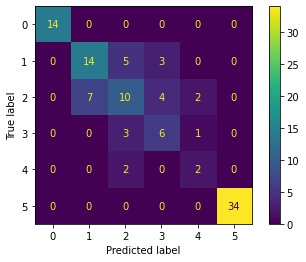

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.67      0.64      0.65        22
           2       0.50      0.43      0.47        23
           3       0.46      0.60      0.52        10
           4       0.40      0.50      0.44         4
           5       1.00      1.00      1.00        34

    accuracy                           0.75       107
   macro avg       0.67      0.70      0.68       107
weighted avg       0.75      0.75      0.75       107

Train accuracy Score: 0.7654320987654321
Test accuracy Score: 0.7476635514018691


In [17]:
#baseline logistic regression for labeled data 
clf = LogisticRegression(max_iter=1000)

clf.fit(X_train_lab, y_train_lab)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train_lab)

train_acc = accuracy_score(y_train_lab, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

cm = metrics.confusion_matrix(y_test, y_pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2,3,4,5])
cm_display.plot()
plt.show()

print(classification_report(y_test, y_pred_test))

print(f"Train accuracy Score: {train_acc}")
print(f"Test accuracy Score: {test_acc}")

## **Self Learning**

Iteration 0
Train acc: 0.7654320987654321
Test acc: 0.7476635514018691
Now predicting labels for unlabeled data...
78 high-probability predictions added to training data.
498 unlabeled instances remaining.

Iteration 1
Train acc: 0.7752688172043011
Test acc: 0.7476635514018691
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
496 unlabeled instances remaining.

Iteration 2
Train acc: 0.7755102040816326
Test acc: 0.7476635514018691
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
496 unlabeled instances remaining.



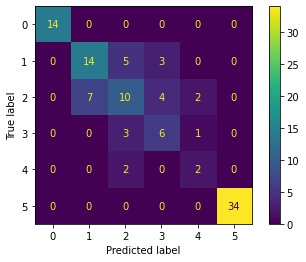

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.67      0.64      0.65        22
           2       0.50      0.43      0.47        23
           3       0.46      0.60      0.52        10
           4       0.40      0.50      0.44         4
           5       1.00      1.00      1.00        34

    accuracy                           0.75       107
   macro avg       0.67      0.70      0.68       107
weighted avg       0.75      0.75      0.75       107



In [18]:
def selflearning_logisticreg(X_train_lab,y_train_lab, X_test, y_test, X_train_unlab):

  # Initiate iteration counter
  iterations = 0

  # Containers to hold accuracy and # of pseudo-labels
  train_accs = []
  test_accs = []
  pseudo_labels = []

  # Assign value to initiate while loop
  high_prob = [1] 

  # Loop will run until there are no more high-probability pseudo-labels
  while len(high_prob) > 0:
          
      # Fit classifier and make train/test predictions
      clf = LogisticRegression(max_iter=1000)
      clf.fit(X_train_lab, y_train_lab)
      y_hat_train = clf.predict(X_train_lab)
      y_hat_test = clf.predict(X_test)

      # Calculate and print iteration # and accuracy scores, and store accuracy scores
      train_acc = accuracy_score(y_train_lab, y_hat_train)
      test_acc = accuracy_score(y_test, y_hat_test)
      print(f"Iteration {iterations}")
      print(f"Train acc: {train_acc}")
      print(f"Test acc: {test_acc}")
      train_accs.append(train_acc)
      test_accs.append(test_acc)
    
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs = clf.predict_proba(X_train_unlab)
      preds = clf.predict(X_train_unlab)
      prob_0 = pred_probs[:,0]
      prob_1 = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob = pd.DataFrame([])
      df_pred_prob['preds'] = preds
      df_pred_prob['prob_0'] = prob_0
      df_pred_prob['prob_1'] = prob_1
      df_pred_prob.index = X_train_unlab.index
      
      # Separate predictions with > 99% probability
      high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.90],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > 0.90]],
                            axis=0)
      
      print(f"{len(high_prob)} high-probability predictions added to training data.")
      
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train_lab = pd.concat([X_train_lab, X_train_unlab.loc[high_prob.index]], axis=0)
      y_train_lab = pd.concat([pd.DataFrame(y_train_lab), high_prob.preds])     
      
      # Drop pseudo-labeled instances from unlabeled data
      X_train_unlab = X_train_unlab.drop(index=high_prob.index)
      print(f"{len(X_train_unlab)} unlabeled instances remaining.\n")
      
      # Update iteration counter
      iterations += 1

  cm = metrics.confusion_matrix(y_test, y_hat_test)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2,3,4,5])
  cm_display.plot()
  plt.show()

  print(classification_report(y_test, y_pred_test))


selflearning_logisticreg(X_train_lab,y_train_lab, X_test, y_test, X_train_unlab)

End of iteration 1, added 321 new labels.
End of iteration 2, added 45 new labels.
End of iteration 3, added 47 new labels.
End of iteration 4, added 20 new labels.
End of iteration 5, added 24 new labels.
End of iteration 6, added 8 new labels.
End of iteration 7, added 9 new labels.
End of iteration 8, added 1 new labels.
Accuracy Score:  0.7822671156004489
Accuracy Score:  0.7663551401869159
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.69      0.82      0.75        22
           2       0.52      0.48      0.50        23
           3       0.50      0.40      0.44        10
           4       0.25      0.25      0.25         4
           5       1.00      1.00      1.00        34

    accuracy                           0.77       107
   macro avg       0.66      0.66      0.66       107
weighted avg       0.76      0.77      0.76       107



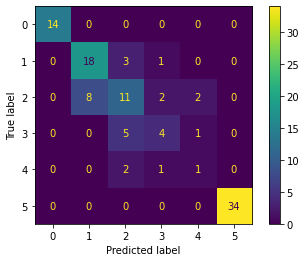

In [19]:
def selftraining_SVC(X_train_lab,y_train_lab, X_test, y_test, X_train_unlab, y_train_unlab):

  X_train = pd.concat([X_train_lab, X_train_unlab])
  y_train = np.concatenate((y_train_lab, y_train_unlab), axis=None)

  model_svc = SVC(kernel='rbf', 
                  probability=True, 
                  C=1.0, 
                  gamma='scale',
                  random_state=0
                )

  self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                              threshold=0.7,
                                              criterion='threshold', 
                                              max_iter=100, 
                                              verbose=True 
                                          )
  clf_ST = self_training_model.fit(X_train, y_train)
  pred = clf_ST.predict(X_test)
  pred_train = clf_ST.predict(X_train_lab)


  accuracy_score_train = accuracy_score(y_train_lab, pred_train)
  print('Accuracy Score: ', accuracy_score_train)

  accuracy_score_test = accuracy_score(y_test, pred)
  print('Accuracy Score: ', accuracy_score_test)
  
  print(classification_report(y_test, pred))

  cm = metrics.confusion_matrix(y_test, pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2,3,4,5])
  cm_display.plot()
  plt.show()


selftraining_SVC(X_train_lab,y_train_lab, X_test, y_test, X_train_unlab, y_train_unlab)

# **Label Spreading and Label Propagation**

In [20]:
X_train = pd.concat([X_train_lab, X_train_unlab])
y_train = np.concatenate((y_train_lab, y_train_unlab), axis=None)
label_prop_model = LabelPropagation(n_neighbors = 5, kernel='rbf')
label_prop_model.fit(X_train, y_train)
pred = label_prop_model.predict(X_test)
pred_train = label_prop_model.predict(X_train_lab)

accuracy_score_train = metrics.accuracy_score( y_train_lab, pred_train)
print('Accuracy Score of the train dataset: ', accuracy_score_train)

accuracy_score_test = metrics.accuracy_score( y_test, pred)
print('Accuracy Score: ', accuracy_score_test)

Accuracy Score of the train dataset:  0.8361391694725028
Accuracy Score:  0.7570093457943925


In [21]:
X_train = pd.concat([X_train_lab, X_train_unlab])
y_train = np.concatenate((y_train_lab, y_train_unlab), axis=None)
model_LS = LabelSpreading(kernel='rbf',
                          gamma=20, 
                          n_neighbors=7,
                          alpha=0.5, 
                          max_iter=100,
                          tol=0.001, 
                          n_jobs=-1, 
                         )
label_sp_model = LabelSpreading()
label_sp_model.fit(X_train, y_train)
pred = label_sp_model.predict(X_test)
pred_train = label_prop_model.predict(X_train_lab)

accuracy_score_train = metrics.accuracy_score( y_train_lab, pred_train)
print('Accuracy Score of the train dataset: ', accuracy_score_train)

accuracy_score_test = metrics.accuracy_score(y_test, pred)
print('Accuracy Score of the test dataset: ', accuracy_score_test)

Accuracy Score of the train dataset:  0.8361391694725028
Accuracy Score of the test dataset:  0.7570093457943925


# **QN-S3VM**

In [22]:
np.unique(y_train_lab, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([297, 297, 297, 297, 297, 297]))

In [23]:
#this piece of code was taken from HW5
#OVR approach - Class 0 
import random
my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [1,2,3,4,5]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))
 

0.8691588785046729


In [24]:
#OVR approach - Class 1 

my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [0,2,3,4,5]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))

0.8691588785046729


In [25]:
#OVR approach - Class 2

my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [0,1,3,4,5]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))

0.8691588785046729


In [26]:
#OVR approach - Class 3

my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [0,1,2,4,5]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))

0.8691588785046729


In [27]:
#OVR approach - Class 4

my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [0,1,2,3,5]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))

0.8691588785046729


In [28]:
#OVR approach - Class 5 

my_random_generator = random.Random()
my_random_generator.seed(0)

xlab = list(np.array(X_train_lab))
ylab = list(np.array(y_train_lab))

for i in range(len(ylab)):
    if ylab[i] in [0,1,2,3,4]:
        ylab[i] = -1
    else:
        ylab[i] = 1

xunlab = list(np.array(X_train_unlab))

xtt = list(np.array(X_test))
ytt = list(np.array(y_test))

for i in range(len(ytt)):
    if ytt[i] in [1,2,3,4,5]:
        ytt[i] = -1
    else:
        ytt[i] = 1

model = QN_S3VM(xlab, ylab, xunlab, my_random_generator)
model.train()
y_pred = model.getPredictions(xtt)
print(accuracy_score(ytt, y_pred))

0.8691588785046729


# **Random Walk - Graph Based and Label Propagation**

In [29]:
#this code was taken from https://github.com/RobRomijnders/ssl_graph 

def gaussian_kernel(std=1.3):
    """
    Makes a kernel function with fixed standard deviation
    :param std: length scale of the  Gaussian kernel
    :return:
    """
    def kernel(x, y=None):
        # Discriminate two cases
        # - when only x is given, the Gram matrix will be symmetric. We can use this fact to save computation
        # - when both x and y are given, then do normal calculation
        if y is None:
            d = squareform(pdist(x))
        else:
            d = cdist(x, y)
        K = np.exp(-1/2*np.square(d/std))
        # Possibly, you can zero-out the contributions from non-neighbors
        # D = K.shape[1]
        # neighbors = 5
        # idx = np.argpartition(K,D-neighbors, axis=1)[:,:D-neighbors]
        # for i,id in enumerate(idx):
        #     K[i,id] = 0
        return K
    return kernel

def generate_data(N):
    """
    data generating function for the two half circles
    :param N:
    :return:
    """
    #Sample random angle
    angle = np.random.rand(N)*5-1

    #Sample random radius
    radius_scale = 0.3
    radius = np.random.rand(N)*2*radius_scale+1.0-radius_scale

    #Convert angle and radius to Carthesian coordinates
    x0 = radius*np.cos(angle)+0.5
    x1 = radius*np.sin(-1*angle)

    lbl = 2*np.random.randint(0,2,size=N)-1

    data = np.vstack((x0,x1)).T

    # Multiply with the labels to get the mirror version of the original half circle
    data = data*np.expand_dims(lbl,1)
    return data,lbl

def generate_data2(N):
    """
    data generating function for the spiral with decreasingly growing radius
    :param N:
    :return:
    """
    alpha_list = [0, float(np.pi)]
    t_max = 10 # max time for which to run the radius

    data = []
    targets = []
    for i, alpha in enumerate(alpha_list):
        N_half = int(N/2)
        t = t_max*np.random.rand(N_half,) #add some noise to the radius :)
        radius = np.sqrt(t)+0.05*np.random.randn(N_half,)
        data.append(np.vstack((radius*np.cos(t+alpha), radius*np.sin(t+alpha))).T)
        targets.append(i*np.ones((N_half,)))

    #Permute the data
    perm = np.random.permutation(N)
    data = np.concatenate(data,0)[perm]
    targets = np.concatenate(targets,0)[perm]
    return data, 2*targets-1


def random_walk(y_labeled, X_labeled, X_unlabeled, X_train, kernel):
    """
    Runs a random walk by calculating the P_infinity matrix. it assumes a model
    where all the labeled points will
    be absorbing states, so P(i->j)=1. The unlabeled points will not have self connections,
    so P(i->j)=0.
    This results in a block structure like
    [[P_ll, P_lu],[P_ul,P_uu]] = [[identity_matrix, zero_matrix],[P_ul,P_uu]]
    :param y_labeled: targets for labeled points
    :param X_labeled:  data for labeled points
    :param X_unlabeled: data for unlabeled points
    :param X_train: data for where to evaluate the label
    :param kernel: kernel function
    :return:
    """
    n_unlabeled = X_unlabeled.shape[0]
    n_labeled = X_labeled.shape[0]
    n_train = X_train.shape[0]

    # from here on, we define X_eval as the data points where we want to EVALuate the labels
    X_eval = np.concatenate((X_unlabeled, X_train), 0)

    # Subfixes refer to the data. _e refers to eval data, _l refers to the labeled data
    # So p_el refers to transition probability from eval data to labeled data
    P_el = kernel(X_eval, X_labeled)
    P_ee = kernel(X_eval, None)

    # Set diagonal of P_ee to zero
    # P_ee -= np.diagonal(P_ee)

    # Normalize the rows to ensure each row represents a transition distribution
    row_sum = np.expand_dims(np.sum(P_el,1)+np.sum(P_ee,1),1)
    P_el /= row_sum
    P_ee /= row_sum

    # Calculate the lower left block of the infinity matrix
    # P_inf = np.linalg.inv(np.eye(n_unlabeled+n_train) - P_ee).dot(P_el)
    P_inf = np.linalg.solve(np.eye(n_unlabeled+n_train) - P_ee, P_el)

    assert P_inf.shape == (n_unlabeled+n_train, n_labeled) #Just to debug the code

    #Calculate the predictions on the final n_train samples
    y_pred = np.dot(P_inf[-n_train:], y_labeled)
    return y_pred

def label_propagation(y_labeled, X_labeled, X_unlabeled, X_train, kernel, mu=1., verbose=False):
    """
    Label propagation algorithm on the data
    :param y_labeled: targets for labeled points
    :param X_labeled:  data for labeled points
    :param X_unlabeled: data for unlabeled points
    :param X_train: data for where to evaluate the label
    :param kernel: kernel function
    :param mu: hyperparameter for the label prop algo
    :param verbose: do you want to print stuff?
    :return:
    """
    n_unlabeled = X_unlabeled.shape[0]
    n_labeled = X_labeled.shape[0]
    n_train = X_train.shape[0]

    # from here on, we define X_eval as the data points where we want to EVALuate the labels
    X_eval = np.concatenate((X_labeled, X_unlabeled, X_train), 0)

    # Subfixes refer to the data. _e refers to eval data, _l refers to the labeled data
    # So p_el refers to transition probability from eval data to labeled data
    W = kernel(X_eval, None)
    D = np.sum(W,0)

    eps = 1E-9 #arbitrary small number

    A = np.diag(np.concatenate((np.ones((n_labeled)), np.zeros((n_unlabeled+n_train)))) + mu*D + mu*eps)

    y_hat_0 = np.concatenate((y_labeled, np.zeros((n_unlabeled+n_train))))
    y_hat = copy(y_hat_0)

    for iter in range(100):
        y_hat_old = y_hat
        y_hat = np.linalg.solve(A, mu*np.dot(W, y_hat)+y_hat_0)

        if np.linalg.norm(y_hat - y_hat_old) < 0.01:
            if verbose:
                print('Converged after %i steps'%iter)
            break
    else:
        if verbose:
            print('Not converged??')

    return y_hat[-n_train:]


def hyperparam_opt_label_prop(y_labeled, X_labeled, X_unlabeled, X_train, y_train, verbose = False):
    ## OLD CODE
    trials = 10
    best_MAE = 1000
    for trial in range(trials):
        mu = np.random.rand()
        std = 0.01+np.random.rand()/2

        y_pred = label_propagation(y_labeled, X_labeled, X_unlabeled, X_train, gaussian_kernel(std), mu = mu, verbose=verbose)
        MAE = np.mean(np.abs(y_pred-y_train))
        accuracy = np.mean(np.equal(y_pred > 0.0, y_train > 0.0))

        if MAE < best_MAE:
            if verbose:
                print('At mu %5.3f and std %5.3f we have MAE %5.3f (and acc %5.3f)'%(mu,std, MAE, accuracy))
            best_MAE = MAE
            best_hyper_param = (std, mu)

    return best_hyper_param

def hyperparam_opt_random_walk(y_labeled, X_labeled, X_unlabeled, X_train, y_train, verbose = False):
    ## OLD CODE
    trials = 10
    best_MAE = 1000
    for trial in range(trials):
        std = 0.01+np.random.rand()/2

        try:
            y_pred = random_walk(y_labeled, X_labeled, X_unlabeled, X_train, gaussian_kernel(std))
        except np.linalg.linalg.LinAlgError:
            y_pred = np.zeros_like(y_train)
        MAE = np.mean(np.abs(y_pred-y_train))
        accuracy = np.mean(np.equal(y_pred > 0.0, y_train > 0.0))

        if MAE < best_MAE:
            if verbose:
                print('At std %5.3f we have MAE %5.3f (and acc %5.3f)'%(std, MAE, accuracy))
            best_MAE = MAE
            best_hyper_param = std
    return best_hyper_param

In [30]:
#Evaluate Random Walk
y_pred = random_walk(y_train_lab, X_train_lab, X_train_unlab, X_test, gaussian_kernel(0.1))
accuracy = np.mean(np.equal(y_pred > 0.0, y_test > 0.0))
print('We have accuracy %5.3f'%(accuracy))
# confusion_matrix(y_pred, ytt)


#Evaluate Label Prop
y_pred = label_propagation(y_train_lab, X_train_lab, X_train_unlab, X_test, gaussian_kernel(0.1), mu = 0.4)
accuracy =np.mean(np.equal(y_pred > 0.0, y_test > 0.0))
print('We have accuracy %5.3f'%(accuracy))
# confusion_matrix(y_pred, ytt)


We have accuracy 0.794
We have accuracy 0.869
